# Notebook 2 - Design of inhibitors against histamine H1 receptor

By Vincent Blay, June 2021

In this notebook, we demonstrate the use of Macaw embeddings to model binding affinity to a protein receptor of pharmacological interest. Macaw embeddings are then applied to identify promising candidate molecules among a custom virtual library.

In [1]:
pwd

'C:\\Users\\Enka\\Desktop\\LDRD\\macaw_repo\\notebooks'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import SVR
from sklearn_rvm import EMRVR

import macaw
print(macaw.__version__)
from macaw import *

%run "./plotting.py"

0.0.6


## 1. Binding to histamine H1 receptor

### 1.1 Data preparation

In [3]:
df = pd.read_csv("../data/data_H1.csv")
Y = df.activity # Y are pKi values
smiles = df.rdkit_smiles
df.head()

,compound_id,rdkit_smiles,activity
0,CHEMBL3925977,O=C(O)c1ccc2cccnc2c1N1CCN(CCc2ccc(OCCCN3CCCCCC...,5.599999
1,CHEMBL2171045,O=C(NS(=O)(=O)c1cccc(C(F)(F)F)c1)N1CCC(N2CCC(O...,7.400008
2,CHEMBL3753784,COc1ccc(CNc2nc(N3CCN(C)CC3)nc3c2CCc2ccccc2-3)c...,5.200000
3,CHEMBL3917794,O=C(O)c1ccc2cccc(N3CCN(CCc4ccc(OCCCN5CCCCCC5)c...,6.599998
4,CHEMBL240394,O=C(c1cc(F)cc(F)c1)N1CCN(c2ccc(OCCCN3CCCCC3)cc...,5.700001


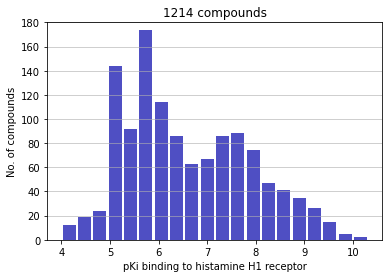

In [4]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

In [5]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

### 1.2 Compute Macaw embeddings

In [6]:
#mcw = Macaw_optimus(smi_train, y_train, fast=False, verbose=True, Y=y_train)
mcw = Macaw(smi_train, edim=15, Nlndmk=50, Y=y_train, fptype='atompairs', metric='sokal')

In [7]:
X_train = mcw.transform()
X_train.shape

(971, 15)

In [8]:
X_test = mcw.transform(smi_test)
X_test.shape

(243, 15)

### 1.3 Modeling using a SVR

In [9]:
for C in [1,3,5,7,10,30,50]:
    regr = SVR(kernel='rbf', C=C, epsilon=.3)
 
    scores = cross_val_score(regr, X_train, y_train, cv = 5)
    print(scores.mean())

0.7019793548616511
0.7105678740853845
0.7127602283015018
0.713272903976008
0.7130612087985213
0.6988555056978736
0.6801083988519346


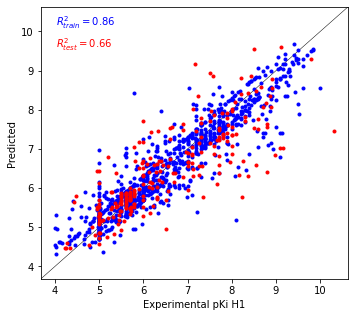

In [10]:
regr = SVR(kernel='rbf', C=10, epsilon=.3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)


# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, 
            xlabel='Experimental pKi H1', savetitle='../data/H1_SVR.png') 

## 2. Binding to muscarinic receptor M2

### 2.1 Data preparation

In [11]:
df = pd.read_csv("../data/data_M2.csv")
Y = df.activity # Y are pKi values
smiles = df.rdkit_smiles
df.head()

,compound_id,rdkit_smiles,activity
0,CHEMBL358493,C[N+]12CCC(CC1)C(O)(c1cc3ccccc3o1)C2,5.259637
1,CHEMBL343236,c1ccc2c(c1)CC(C1CN3CCC1CC3)O2,6.309894
2,CHEMBL150845,CC(=C1CCN(C2CCN(C(=O)c3ccc(F)c4ccccc34)CC2)CC1...,8.017729
3,CHEMBL593871,C[C@H]1OC[C@@H](C[N+](C)(C)C)O[C@@H]1C,4.780000
4,CHEMBL91404,CCOC(=O)N1CCC(N2CCC(C(=O)c3ccc(S(=O)(=O)c4ccc5...,9.886057


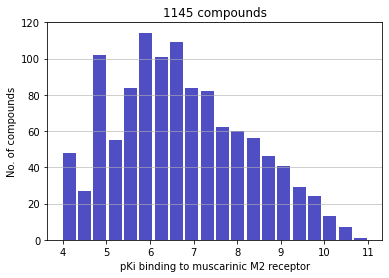

In [12]:
plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [13]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size = 0.2, random_state = 42)

### 2.2 Compute Macaw embeddings

In [14]:
#mcw2 = Macaw_optimus(smi_train, y_train, fast=False, verbose=True, Y=y_train)
mcw2 = Macaw(smi_train, edim = 15, Nlndmk = 50, Y = y_train, fptype='atompairs', metric='rogot-goldberg')

In [15]:
X_train = mcw2.transform()
X_train.shape

X_test = mcw2.transform(smi_test)
X_test.shape

(229, 15)

### 2.3 Modeling using a SVR

In [16]:
for C in [1,3,5,10,30]:
    regr2 = SVR(kernel='rbf', C=C, epsilon=.5)
 
    scores = cross_val_score(regr2, X_train, y_train, cv = 5)
    print(scores.mean())

0.6566963040404954
0.6838343342146029
0.6844544533008639
0.6807567558348051
0.6617871926299509


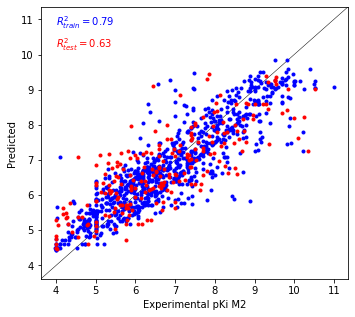

In [17]:
regr2 = SVR(kernel='rbf', C=3, epsilon=.5)
regr2.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr2.predict(X_train)

# Test set predictions
y_test_pred = regr2.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Experimental pKi M2", savetitle="../data/M2_SVR.png")

## 3. Discovery of new hits specific to H1

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` and `regr2` above, which use 15-D Macaw embeddings as their input. The custom library ("LibraryVB.csv") is a custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted binding affinity to the H1 receptor and comparatively low predicted binding affinity to the M2 receptor.

In [19]:
mylib = pd.read_csv("../data/LibraryVB.csv")
print(mylib.shape)
mylib.head()

(19490, 2)


,Smiles,Source
0,NC(=O)NC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
1,CC(C)CNC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
2,O=C(Cn1cccnc1=O)NC1CCCCCC1,Enamine_antivirals
3,CCC(=O)Nc1ccc(cn1)N1CCOCC1,Enamine_antivirals
4,Cc1nn(C)c(C)c1CC(=O)NC(C1CC1)C1CC1,Enamine_antivirals


In [20]:
smi_lib = mylib.Smiles

In [21]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr.predict(X1_lib)

In [22]:
X2_lib = mcw2.transform(smi_lib)

Y2_lib_pred = regr2.predict(X2_lib)

Let us represent the predictions of both models:

<Figure size 468x396 with 0 Axes>

Text(0.5, 0, 'Predicted pKi M2')

Text(0, 0.5, 'Predicted pKi H1')

Text(0.5, 1.0, 'Virtual screening of custom library (19,490 molecules)')

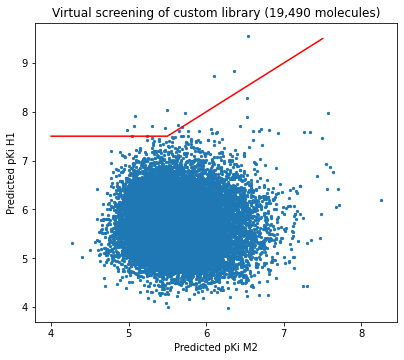

In [29]:
plt.figure(figsize=(6.5,5.5))
plt.scatter(x=Y2_lib_pred,y=Y1_lib_pred,s=5) 
plt.xlabel("Predicted pKi M2")
plt.ylabel("Predicted pKi H1")
plt.title("Virtual screening of custom library (19,490 molecules)")
plt.plot([4,5.5,7.5],[7.5,7.5,9.5],c='red')
plt.savefig("../data/H1_library_screening.png")

Let us have a look at the compounds:

In [25]:
indx = np.where((Y1_lib_pred > 7.5)*(Y1_lib_pred > (Y2_lib_pred + 2)))[0]

13


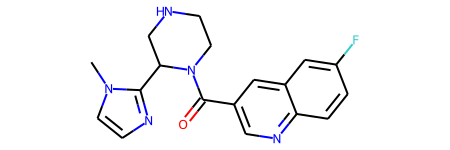

7.509053455829518
5.041923955798707


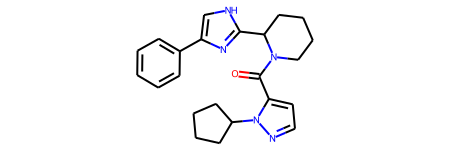

7.510089775517729
5.234127303075377


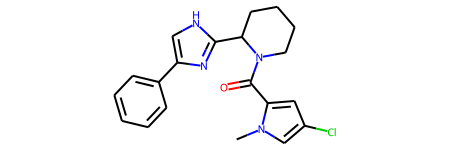

8.04418360652544
5.499176808431175


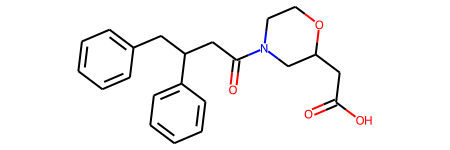

7.661682157310869
5.465581954961314


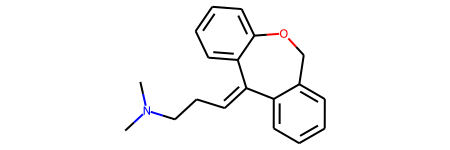

9.543504125993167
6.536152263535637


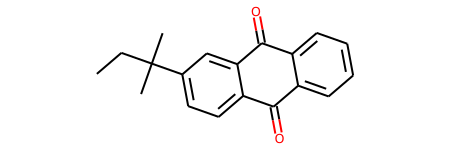

7.621742448798884
4.983374455852674


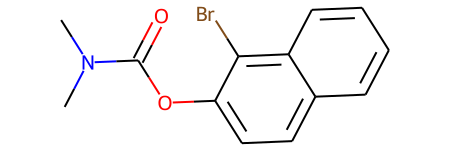

7.70294020479401
5.065557190861412


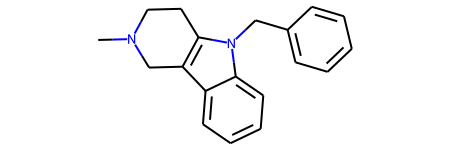

7.728616847589699
5.636433961037522


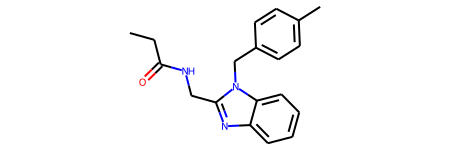

7.704762361373588
5.300136209007018


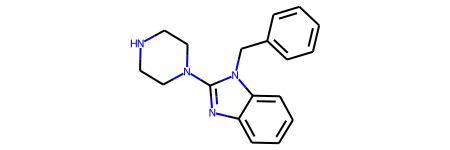

7.922057993858957
5.081807907106243


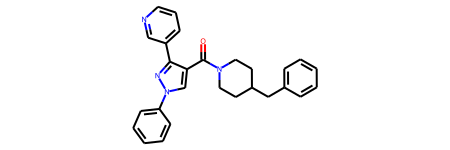

7.974946301517436
5.730963475679408


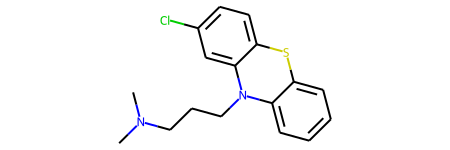

8.839214872605792
6.351410982145143


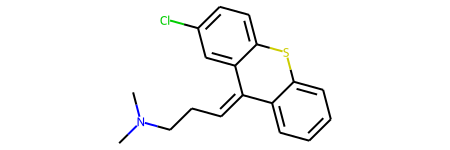

8.72617212409091
6.093348531525187


In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(len(indx))

for i in indx:
    MolFromSmiles(smi_lib.iloc[i])
    print(Y1_lib_pred[i])
    print(Y2_lib_pred[i])

In [27]:
lead_df = mylib.iloc[indx].copy()
lead_df['pKi_H1_pred'] = Y1_lib_pred[indx]
lead_df['pKi_M2_pred'] = Y2_lib_pred[indx]

lead_df

,Smiles,Source,pKi_H1_pred,pKi_M2_pred
3654,Cn1ccnc1C1CNCCN1C(=O)c1cnc2ccc(F)cc2c1,Enamine_DDS464,7.509053,5.041924
3927,O=C(N1CCCCC1c1nc(c[nH]1)c1ccccc1)c1ccnn1C1CCCC1,Enamine_DDS737,7.510090,5.234127
8973,Cn1cc(Cl)cc1C(=O)N1CCCCC1c1nc(c[nH]1)c1ccccc1,Enamine_DDS5783,8.044184,5.499177
12443,OC(=O)CC1CN(CCO1)C(=O)CC(Cc1ccccc1)c1ccccc1,Enamine_DDS9253,7.661682,5.465582
13946,CN(C)CC/C=C\1/c2ccccc2COc2ccccc12,Enamine_Phenotypic,9.543504,6.536152
14290,CCC(C)(C)c1ccc2C(=O)c3ccccc3C(=O)c2c1,Enamine_Phenotypic,7.621742,4.983374
15389,CN(C)C(=O)Oc1ccc2ccccc2c1Br,Enamine_Phenotypic,7.702940,5.065557
15419,CN1CCc2c(C1)c1ccccc1n2Cc1ccccc1,Enamine_Phenotypic,7.728617,5.636434
15983,CCC(=O)NCc1nc2ccccc2n1Cc1ccc(C)cc1,Enamine_Phenotypic,7.704762,5.300136
17743,C(c1ccccc1)n1c(nc2ccccc12)N1CCNCC1,Enamine_Phenotypic,7.922058,5.081808
